# GASPRA Solver.py presentation

<div class="alert alert-block alert-info">
<b>Team Member:</b> Karim Bacchus, Weilin zhang, Vagif A, Yitong Jin, Andika Hakim
</div>

## what are the outputs :
* Calculate velocity, mass , angle, distance, radius, time, and kinectic energy along with its derivation to altitude each time step with Forward Euler or Runge Kutta 4th order.
* Make a simple conclusion to the meteor based on if condition whether it will be an airburst, crating, or combination from airburst and crating.
* Make velocity profile based on altitude derived analytically and compared with numerical solution.

Below code is the code taken from solver.py

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

class Planet():
    """
    The class called Planet is initialised with constants appropriate
    for the given target planet, including the atmospheric density profile
    and other constants
    """

    def __init__(self, atmos_func='exponential', atmos_filename=None,
                 Cd=1., Ch=0.1, Q=1e7, Cl=1e-3, alpha=0.3, Rp=6371e3,
                 g=9.81, H=8000., rho0=1.2):
        """
        Set up the initial parameters and constants for the target planet

        Parameters
        ----------

        atmos_func : string, optional
            Function which computes atmospheric density, rho, at altitude, z.
            Default is the exponential function ``rho = rho0 exp(-z/H)``.
            Options are ``exponential``, ``tabular``, ``constant`` and ``mars``

        atmos_filename : string, optional
            If ``atmos_func`` = ``'tabular'``, then set the filename of the table
            to be read in here.

        Cd : float, optional
            The drag coefficient

        Ch : float, optional
            The heat transfer coefficient

        Q : float, optional
            The heat of ablation (J/kg)

        Cl : float, optional
            Lift coefficient

        alpha : float, optional
            Dispersion coefficient

        Rp : float, optional
            Planet radius (m)

        rho0 : float, optional
            Air density at zero altitude (kg/m^3)

        g : float, optional
            Surface gravity (m/s^2)

        H : float, optional
            Atmospheric scale height (m)

        Returns
        -------

        None
        """

        # Input constants
        self.Cd = Cd
        self.Ch = Ch
        self.Q = Q
        self.Cl = Cl
        self.alpha = alpha
        self.Rp = Rp
        self.g = g
        self.H = H
        self.rho0 = rho0
        
        if atmos_func == 'exponential':
            self.rhoa = lambda z: self.rho0 * np.exp(-z / self.H)
        elif atmos_func == 'tabular':
            self.atmos = pd.read_csv(atmos_filename, skiprows=6, delimiter=' ', names = ['Altitude', 'Density', 'Height'])
            self.rhoa = lambda z: self.tabulate(z)
        elif atmos_func == 'mars':
            self.rhoa = lambda z: self.marsdensity(z)
        elif atmos_func == 'constant':
            self.rhoa = lambda z: rho0
        else:
            raise NotImplementedError

     
    def marsdensity(self, z):
        '''
        Solve mars density for given height for everytime step

        Parameters
        ----------
        z = altitude (float) 

        Returns
        ---------
        mars density for given height
        '''
        p = 0.699*np.exp(-0.00009*z)
        if z >= 7000:
            T = 249.7 - 0.00222*z
        else:
            T = 242.1 - 0.000998*z
        marsdensity = p / (0.1921*T)
        return marsdensity 

    def tabulate(self, z):
        """
        provides values tabulated atmospheric density profile from  from Z to 0   
        z is rounded to the nearest 10

        Parameters
        ----------
        z = altitude (float) 

        Returns
        ---------
        abulated atmospheric density for given height
        """
        ans_index = self.atmos.Altitude.values.searchsorted(z) - 1
        density = self.atmos.iloc[ans_index]['Density'] * np.exp((self.atmos.iloc[ans_index]['Altitude'] - z)/self.atmos.iloc[ans_index]['Height'])
        return density
        
    def deg_to_rad(self, deg):
        """
        Returns an angle in radians
        for a given angle in degrees
        """
        return np.round(deg * np.pi / 180,5)

    def rad_to_degrees(self, rad):
        """
        Returns an angle in degrees
        for a given angle in radians
        """
        return np.round(rad*180 / np.pi,2)

    def impact(self, radius, velocity, density, strength, angle,
               init_altitude=100e3, dt=0.05, radians=False):
        """
        Solve the system of differential equations for a given impact event.
        Also calculates the kinetic energy lost per unit altitude and
        analyses the result to determine the outcome of the impact.

        Parameters
        ----------

        radius : float
            The radius of the asteroid in meters

        velocity : float
            The entery speed of the asteroid in meters/second

        density : float
            The density of the asteroid in kg/m^3

        strength : float
            The strength of the asteroid (i.e., the ram pressure above which
            fragmentation and spreading occurs) in N/m^2 (Pa)

        angle : float
            The initial trajectory angle of the asteroid to the horizontal
            By default, input is in degrees. If 'radians' is set to True, the
            input should be in radians

        init_altitude : float, optional
            Initial altitude in m

        dt : float, optional
            The output timestep, in s

        radians : logical, optional
            Whether angles should be given in degrees or radians. Default=False
            Angles returned in the DataFrame will have the same units as the
            input

        Returns
        -------

        Result : DataFrame
            A pandas DataFrame containing the solution to the system.
            Includes the following columns:
            ``velocity``, ``mass``, ``angle``, ``altitude``,
            ``distance``, ``radius``, ``time``, ``dedz``

        outcome : Dict
            dictionary with details of airburst and/or cratering event.
            For an airburst, this will contain the following keys:
            ``burst_peak_dedz``, ``burst_altitude``, ``burst_total_ke_lost``.

            For a cratering event, this will contain the following keys:
            ``impact_time``, ``impact_mass``, ``impact_speed``.

            All events should also contain an entry with the key ``outcome``,
            which should contain one of the following strings:
            ``Airburst``, ``Cratering`` or ``Airburst and cratering``
        """
        result = self.solve_atmospheric_entry(radius, velocity, density, strength, angle)
        result = self.calculate_energy(result)
        outcome = self.analyse_outcome(result)
        return result, outcome

    def solve_atmospheric_entry(
            self, radius, velocity, density, strength, angle, method='RK45',
            init_altitude=100e3, dt=0.05, radians=False):
        """
        Solve the system of differential equations for a given impact scenario

        Parameters
        ----------

        radius : float
            The radius of the asteroid in meters

        velocity : float
            The entery speed of the asteroid in meters/second

        density : float
            The density of the asteroid in kg/m^3

        strength : float
            The strength of the asteroid (i.e., the ram pressure above which
            fragmentation and spreading occurs) in N/m^2 (Pa)

        angle : float
            The initial trajectory angle of the asteroid to the horizontal
            By default, input is in degrees. If 'radians' is set to True, the
            input should be in radians
        
        method : Runge Kutta 4th Order ('RK45') or Forward Euler ('FE')

        init_altitude : float, optional
            Initial altitude in m

        dt : float, optional
            The output timestep, in s

        radians : logical, optional
            Whether angles should be given in degrees or radians. Default=False
            Angles returned in the DataFrame will have the same units as the
            input

        Returns
        -------
        Result : DataFrame
            A pandas DataFrame containing the solution to the system.
            Includes the following columns:
            ``velocity``, ``mass``, ``angle``, ``altitude``,
            ``distance``, ``radius``, ``time``
        """
        # initial state in order : [0] v [1] m [2] theta [3] z [4] x [5] r 
        # distance for (t=0) is assumed to be 0
        if radians == False :
            initial_state = np.array([velocity, density*4/3*np.pi*radius**3, self.deg_to_rad(angle), init_altitude, 0, radius])
        elif radians == True :
            initial_state = np.array([velocity, density*4/3*np.pi*radius**3, angle, init_altitude, 0, radius])
        
        if method == 'RK45':
            state, time = self.RK_45(self.f_com, initial_state, strength, density) 
        elif method == 'FE':
            state, time = self.forward_euler(self.f_com, initial_state, strength, density) 
        else :
            raise NameError('Please select between RK45 or Forward Euler')
        result = pd.DataFrame({'velocity': state[:,0],
                             'mass': state[:,1],
                             'angle': self.rad_to_degrees(state[:,2]),
                             'altitude': state[:,3],
                             'distance': state[:,4],
                             'radius': state[:,5],
                             'time': time})
        return result

    def calculate_energy(self, result):
        """
        Function to calculate the kinetic energy lost per unit altitude in
        kilotons TNT per km, for a given solution.

        Parameters
        ----------

        result : DataFrame
            A pandas DataFrame with columns for the velocity, mass, angle,
            altitude, horizontal distance and radius as a function of time

        Returns
        -------

        Result : DataFrame
            Returns the DataFrame with additional column ``dedz`` which is the
            kinetic energy lost per unit altitude
        """
        result = result.copy()
        result = result.to_numpy()
        dedz = np.array((0.5*result[1:,1]*(result[1:,0]**2) - 0.5*result[:-1,1]*(result[:-1,0]**2))/(result[1:,3]-result[:-1,3]))
        dedz = np.insert(dedz,0,0)
        result = pd.DataFrame({'velocity': result[:,0],
                             'mass': result[:,1],
                             'angle': result[:,2],
                             'altitude': result[:,3],
                             'distance': result[:,4],
                             'radius': result[:,5],
                             'time': result[:,6],
                             'dedz': dedz / 4.184e9})
        return result        

    def analyse_outcome(self, result):
        """
        Inspect a prefound solution to calculate the impact and airburst stats

        Parameters
        ----------

        result : DataFrame
            pandas DataFrame with velocity, mass, angle, altitude, horizontal
            distance, radius and dedz as a function of time

        Returns
        -------

        outcome : Dict
            dictionary with details of airburst and/or cratering event.
            For an airburst, this will contain the following keys:
            ``burst_peak_dedz``, ``burst_altitude``, ``burst_total_ke_lost``.

            For a cratering event, this will contain the following keys:
            ``impact_time``, ``impact_mass``, ``impact_speed``.

            All events should also contain an entry with the key ``outcome``,
            which should contain one of the following strings:
            ``Airburst``, ``Cratering`` or ``Airburst and cratering``
        """
        dedz_of_burst = result.dedz.max()
        row_of_burst = result.dedz.idxmax()
        burst_altitude = result.altitude[row_of_burst]

        burst_total_ke_lost = (1/2*(result['mass'][0]*result['velocity'][0]**2-result['mass'][row_of_burst]*result['velocity'][row_of_burst]**2))/ 4.184e12

        impact_time = result.at[row_of_burst,'time']
        impact_mass = result.at[row_of_burst,'mass']
        impact_speed = result.at[row_of_burst,'velocity']

        outcome={}
        if burst_altitude>5000:
            outcome["outcome"] = "Airburst"
            outcome["burst_peak_dedz"] = dedz_of_burst
            outcome["burst_altitude"] = burst_altitude
            outcome["burst_total_ke_lost"] = burst_total_ke_lost
        elif (burst_altitude<5000 and burst_altitude>0):
            outcome["outcome"] = "Airburst and cratering"
            outcome["burst_peak_dedz"] = dedz_of_burst
            outcome["burst_altitude"] = burst_altitude
            outcome["burst_total_ke_lost"] = burst_total_ke_lost           
        else:
            outcome["outcome"] = "Cratering"
            outcome["impact_time"] = impact_time
            outcome["impact_mass"] = impact_mass
            outcome["impact_speed"] = impact_speed

        return outcome

    def f_com(self, t, state, strength,density):
        '''
        Composite of derivative function of velocity, mass, angle, altitude, distance, radius (in order)
        Parameters
        ----------
        t : time step
        
        state : array or list
            composite of current condition of velocity, mass, angle, altitude, distance, radius (in order) for every time step calculation
        strength : float
            The strength of the asteroid (i.e., the ram pressure above which
            fragmentation and spreading occurs) in N/m^2 (Pa) 
        density : float
            The density of the asteroid in kg/m^3                

        Returns
        -------------
        a Numpy array containing derivative result of velocity, mass, angle, altitude, distance, radius (in order)
        '''
        v, m, theta, z, x, r = state
        f = np.zeros_like(state)
        A = np.pi * r**2
        # derivative function in order : [0] dv [1] dm [2] dtheta [3] dz [4] dx [5] dr
        f[0] = ((-self.Cd * self.rhoa(z)* A * v**2) / (2 * m)) + (self.g * np.sin(theta))
        f[1] = (-self.Ch * self.rhoa(z) * A * v**3) / (2* self.Q)
        f[2] = (self.g * np.cos(theta) / v) - (self.Cl * self.rhoa(z) * A * v / (2 * m)) - (v * np.cos(theta) / (self.Rp + z))
        f[3] = -v * np.sin(theta)
        f[4] = (v * np.cos(theta)) / (1 + (z / self.Rp))
        f[5] = (np.sqrt((7/2 * self.alpha * self.rhoa(z) / density)) * v if self.rhoa(z)*v**2 >= strength else 0)
        return f

    def RK_45(self, f, initial_state, strength, density,  t0=0.0, t_max=20000, dt=0.05 ):
        '''
            Return velocity, mass, angle, altitude, distance, radius (in order) calculation for each time step using Runge_Kutta 4th order
            Please note this function will consider burst effect in dr/dt calculation
            Parameters
            ----------
            f : function
                composite of derivative function of velocity, mass, angle, altitude, distance, radius (in order)
            
            initial state : array or list
                composite of initial condition of velocity, mass, angle, altitude, distance, radius (in order)

            t0 = float
                initial time

            t_max = float
                End of ODE calculation
            
            dt = float, optional
                Output time step, in s

            Returns
            -------------
            a Numpy array containing velocity, mass, angle, altitude, distance, radius (in order)
        '''
        u = np.array(initial_state)
        U_all = [u]
        t = np.array(t0)
        t_all = [t0]           
        while t < t_max:
            k1 = dt*f(t, u, strength, density)
            k2 = dt*f(t + 0.5*dt, u + 0.5*k1, strength, density)
            k3 = dt*f(t + 0.5*dt, u + 0.5*k2, strength, density)
            k4 = dt*f(t + dt, u + k3, strength, density)
            u = u + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
            U_all.append(u)
            t = t + dt
            t_all.append(t)
            if u[3] < 0:
                break
            if u[1] < 0:
                break    
        return np.array(U_all), np.array(t_all)

    def forward_euler(self, f, initial_state, strength, density, t0=0.0, t_max=20000, dt=0.05):
        '''
            Return velocity, mass, angle, altitude, distance, radius (in order) calculation for each time step 
                    using Forward Euler
            Please note this function will consider burst effect in dr/dt calculation
            Parameters
            ----------
            f : function
                composite of derivative function of velocity, mass, angle, altitude, distance, radius (in order)
            
            initial state : array or list
                composite of initial condition of velocity, mass, angle, altitude, distance, radius (in order)

            t0 = float
                initial time

            t_max = float
                End of ODE calculation
            
            dt = float, optional
                Output time step, in s

            Returns
            -------------
            a Numpy array containing velocity, mass, angle, altitude, distance, radius (in order)
        '''
        u = np.array(initial_state)
        U_all = [u]
        t = np.array(t0)
        t_all = [t0]    
        while t < t_max:
            u = u + dt*f(t, u, strength, density)  # euler guess
            U_all.append(u)
            t = t + dt
            t_all.append(t)
            if u[3] < 0:
                break
            if u[1] < 0:
                break   
        return np.array(U_all), np.array(t_all)
    
    def compare_analytical_numerical(self, radius, velocity, density, strength, angle, 
        init_altitude=100e3, n=100, radians=False):
        """
            Provides comparison analytical solutions and numerical to the ODEs in simplified scenario

            Parameters
            ---------
            radius : float
                The radius of the asteroid in meters

            velocity : float
                The entery speed of the asteroid in meters/second

            density : float
                The density of the asteroid in kg/m^3

            strength : float
                The strength of the asteroid (i.e., the ram pressure above which
                fragmentation and spreading occurs) in N/m^2 (Pa)

            angle : float
                The initial trajectory angle of the asteroid to the horizontal

            init_altitude : float, optional
                Initial altitude in m

            n: integer, optional
                number of data points in analytical solution to compute 
                
            radians : logical, optional
                Whether angles should be given in degrees or radians. Default=False
                Angles returned in the DataFrame will have the same units as the
                input

            Returns
            -------
            five arrays :
            
            v  : velocity profile from analytical method
            
            z  : altitude profile from analytical method
            
            state_numerical  : velocity, mass, angle ,altitude, distance, radius, profile from numerical method
                                using gaspra solver
            
            time_numerical  : time profile from numerical method using gaspra solver
            
            result_sci : velocity, mass, angle ,altitude, distance, radius, profile time profile from numerical method using 
                        Scipy built RK-45 method
        """
        if radians == False: 
            angle *= np.pi/180        
        # calculating constants 
        A = np.pi*radius*radius
        # mass = density * volume
        m = density*A*(4/3)*radius
        beta = -self.H*self.Cd*A/(2*m*np.sin(angle)) 
        C = beta * np.exp(-init_altitude/self.H) - np.log(velocity)

        # Now computing v against height z
        z = np.linspace(init_altitude, 0, n)
        v = np.exp(beta*np.exp(-z/self.H) -C)
        
        ## Numerical part
        t_max = 20000
        tol = 1e-6
        initial_state = np.array([velocity, density*4/3*np.pi*radius**3, angle, init_altitude, 0, radius]) 
        state_numerical, time_numerical = self.RK_45_analytical(self.f_com_analytical, initial_state)
        result_sci = solve_ivp(self.f_com_analytical, (0, t_max), initial_state, t_eval=None, method='RK45', atol=tol, rtol=tol)
    
        ## Plotting part
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.plot(z,v, 'ko', label = 'Analytical')
        ax.plot(state_numerical[:,3], state_numerical[:,0], 'bx', label = 'User created RK-45')
        ax.plot(result_sci.y[3], result_sci.y[0], 'r', label = 'Scipy Built-in RK-45 ')
        ax.set_xlim(state_numerical[-1,3], state_numerical[0,3])
        ax.set_xlabel('v')
        ax.set_ylim(state_numerical[-1,0], state_numerical[0,0])
        ax.set_ylabel('z')
        ax.legend(loc='best')
        plt.show()
        return z, v, state_numerical, time_numerical, result_sci     

    def f_com_analytical(self, t, state):
        '''
        Composite of derivative function of velocity, mass, angle, altitude, distance, radius (in order)
        Parameters in simple scenario
        ----------
        t : time step
        
        state : array or list
            composite of current condition of velocity, mass, angle, altitude, distance, radius (in order) for every time step calculation

        Returns
        -------------
        a Numpy array containing derivative result of velocity, mass, angle, altitude, distance, radius (in order)
        '''
        v, m, theta, z, x, r = state
        f = np.zeros_like(state)
        A = np.pi * r**2
        # derivative function in order : [0] dv [1] dm [2] dtheta [3] dz [4] dx [5] dr
        f[0] = (-self.Cd * self.rhoa(z)* A * v**2) / (2 * m)
        f[1] = 0
        f[2] = 0
        f[3] = -v * np.sin(theta)
        f[4] = v * np.cos(theta)
        f[5] = 0
        return f

    def RK_45_analytical(self, f, initial_state,  t0=0.0, t_max=20000, dt=0.05 ):
            '''
            Return velocity, mass, angle, altitude, distance, radius (in order) calculation for each time step 
            using Runge_Kutta 4th order in simple scenario
            Please note this function will consider burst effect in dr/dt calculation
            Parameters
            ----------
            f : function
                composite of derivative function of velocity, mass, angle, altitude, distance, radius (in order)
            
            initial state : array or list
                composite of initial condition of velocity, mass, angle, altitude, distance, radius (in order)

            t0 = float
                initial time

            t_max = float
                End of ODE calculation
            
            dt = float, optional
                Output time step, in s

            Returns
            -------------
            a Numpy array containing velocity, mass, angle, altitude, distance, radius (in order)
            '''
            u = np.array(initial_state)
            U_all = [u]
            t = np.array(t0)
            t_all = [t0]           
            while t < t_max:
                k1 = dt*f(t, u)
                k2 = dt*f(t + 0.5*dt, u + 0.5*k1)
                k3 = dt*f(t + 0.5*dt, u + 0.5*k2)
                k4 = dt*f(t + dt, u + k3)
                u = u + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
                U_all.append(u)
                t = t + dt
                t_all.append(t)
                if u[3] < 0:
                    break
                if u[1] < 0:
                    break    
            return np.array(U_all), np.array(t_all)

    def plot_analysis(self, result): 
        '''
        Return calculated parameters in data frame and make plot from it
        Parameters
        ----------
        result : data frame
            data frame containing velocity, mass, angle, altitude, distance, radius, time, and dedz (in order)
    
        Returns
        -------------
        Seven chart with different parameters based on data
        '''
        fig, axes = plt.subplots(3, 2, figsize=(12,8), sharex=True)
        result.plot(kind='line', x='altitude', y='velocity',ax = axes[0,0], title = 'velocity', grid=True)
        result.plot(kind='line', x='altitude', y='mass',ax = axes[0,1], title = 'mass', grid=True)
        result.plot(kind='line', x='altitude', y='angle',ax = axes[1,0], title = 'angle', grid=True)
        result.plot(kind='line', x='altitude', y='distance',ax = axes[1,1], title = 'distance', grid=True)
        result.plot(kind='line', x='altitude', y='radius',ax = axes[2,0], title = 'radius', grid=True)
        result.plot(kind='line', x='altitude', y='time',ax = axes[2,1], title = 'time', grid=True)
        plt.show()
        ax1 = plt.gca()
        max_row_id = result['dedz'].idxmax()
        max_dedz = result['dedz'].max()
        max_dedz_altitude = result['altitude'][max_row_id]
        result.plot(kind='line', x='altitude', y='dedz',ax = ax1, grid=True, figsize=(12,6))
        plt.plot(max_dedz_altitude, max_dedz, 'ro' )
        plt.annotate(('(%g , %.2f)' %(max_dedz_altitude, max_dedz)), xy=(max_dedz_altitude, max_dedz))
        plt.grid(True)
        plt.show() 
        
    def error_analysis(self,radius, velocity, density, strength, angle, 
        init_altitude=100e3, radians=False ):
        
        if radians == False: 
            angle *= np.pi/180  
        # calculating constants 
        A = np.pi*radius*radius
        # mass = density * volume
        m = density*A*(4/3)*radius
        beta = -self.H*self.Cd*A/(2*m*np.sin(angle)) 
        C = beta * np.exp(-init_altitude/self.H) - np.log(velocity)
        dts = np.linspace(0.01, 0.2, 20)
        errors_rk45 = np.zeros((len(dts)), dtype=float)
        initial_state = np.array([velocity, density*4/3*np.pi*radius**3, angle, init_altitude, 0, radius]) 
        for i, dt in enumerate(dts):
            state_numerical, time_numerical = self.RK_45_analytical(self.f_com_analytical, initial_state,dt=dt)
            v_analytical = np.zeros(len(state_numerical[:,3]))
            v_analytical = (np.exp(beta*np.exp(-state_numerical[:,3]/self.H)-C))
            errors_rk45[i] = np.linalg.norm((state_numerical[:,0] - v_analytical)) / np.sqrt(len(v_analytical))
            print(errors_rk45[i])
        plt.loglog(dts, errors_rk45)
        plt.xlabel('dt')
        plt.ylabel('RMS')
        plt.show()
        return errors_rk45[i] 

#### Calculate velocity, mass , angle, distance, radius, time, and kinectic energy along with its derivation to altitude each time step with Forward Euler or Runge Kutta 4th order. And analyses the outcome

For this process, there are two ways to determine all differential equations for a given impact event, calculate the kinetic energy lost per unit altitude and analyse the result to determine the outcome of the impact. and use plot_analysis function to 

1. Using impact function. It takes Meteorite initial condition and will run all the calculation until t = 2000 s or when the meteor has reached the ground or mass has been lost. It will return one data frame containing velocity, mass, angle, altitude, distance, radius, time, and dedz. And also simple conclusion about what happened with the meteor. 

To plot the result we use plot_analysis to see all the parameters over altitude

          velocity          mass  angle       altitude      distance  \
0     20000.000000  1.256637e+07  45.00  100000.000000      0.000000   
1     20000.345652  1.256637e+07  44.99   99292.918316    696.254244   
2     20000.691163  1.256636e+07  44.99   98585.889443   1392.660632   
3     20001.036525  1.256636e+07  44.98   97878.913411   2089.219198   
4     20001.381726  1.256636e+07  44.98   97171.990248   2785.929976   
5     20001.726754  1.256635e+07  44.97   96465.119986   3482.793000   
6     20002.071596  1.256635e+07  44.97   95758.302655   4179.808304   
7     20002.416239  1.256634e+07  44.96   95051.538286   4876.975920   
8     20002.760666  1.256634e+07  44.96   94344.826910   5574.295881   
9     20003.104860  1.256633e+07  44.95   93638.168559   6271.768218   
10    20003.448803  1.256633e+07  44.95   92931.563267   6969.392964   
11    20003.792475  1.256632e+07  44.94   92225.011067   7667.170148   
12    20004.135854  1.256631e+07  44.94   91518.511993   8365.09

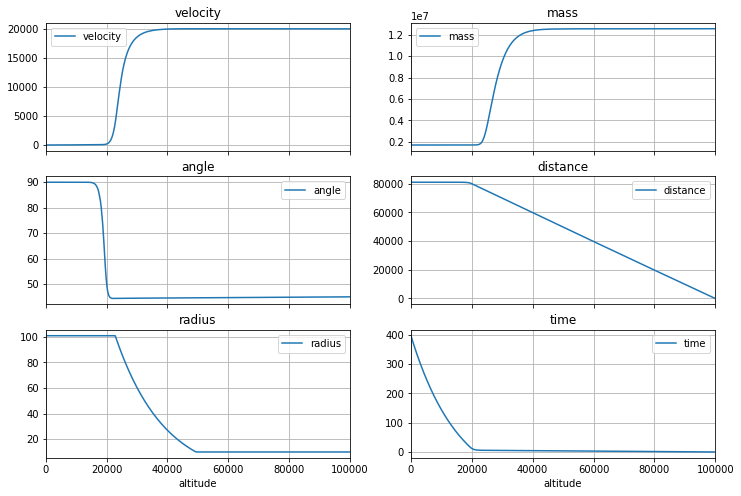

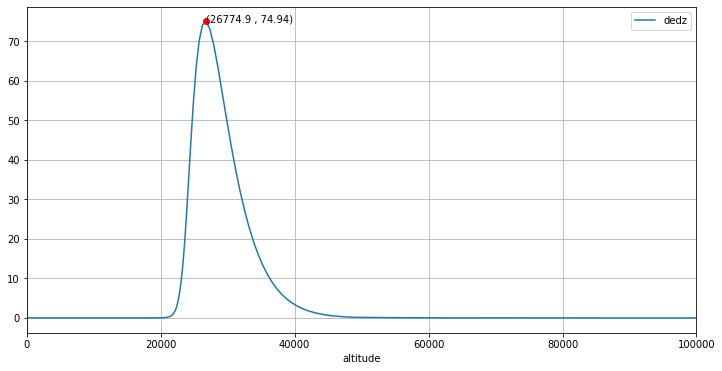

In [2]:
earth = Planet()
result, outcome = earth.impact(10, 20000, 3000, 10e5, 45)
print(result)
print(outcome)
a = earth.plot_analysis(result)

#### Calculate velocity, mass , angle, distance, radius, time, and kinectic energy along with its derivation to altitude each time step with Forward Euler or Runge Kutta 4th order. And analyses the outcome

2. Using three function subsequently. 

> First use solve_atmospheric_entry function which gives us a date frame containing velocity, mass, angle, altitude, distance, radius, time for each time step from given initial condition.

> Second, use calculate_energy from solve_atmospheric_entry funciton result and return additional one column in the data frame containing dedz

> Last, use analyse_outcome to evaluate and make conclusion to the meteor. 

The result from impact function will be similar with these three subsequent function

To plot the result we use plot_analysis to see all the parameters over altitude


In [3]:
earth = Planet()
result_2 = earth.solve_atmospheric_entry(10, 20000, 3000, 10e5, 45)
result_2 = earth.calculate_energy(result)
print(result)
a_2 = earth.analyse_outcome(result)

          velocity          mass  angle       altitude      distance  \
0     20000.000000  1.256637e+07  45.00  100000.000000      0.000000   
1     20000.345652  1.256637e+07  44.99   99292.918316    696.254244   
2     20000.691163  1.256636e+07  44.99   98585.889443   1392.660632   
3     20001.036525  1.256636e+07  44.98   97878.913411   2089.219198   
4     20001.381726  1.256636e+07  44.98   97171.990248   2785.929976   
5     20001.726754  1.256635e+07  44.97   96465.119986   3482.793000   
6     20002.071596  1.256635e+07  44.97   95758.302655   4179.808304   
7     20002.416239  1.256634e+07  44.96   95051.538286   4876.975920   
8     20002.760666  1.256634e+07  44.96   94344.826910   5574.295881   
9     20003.104860  1.256633e+07  44.95   93638.168559   6271.768218   
10    20003.448803  1.256633e+07  44.95   92931.563267   6969.392964   
11    20003.792475  1.256632e+07  44.94   92225.011067   7667.170148   
12    20004.135854  1.256631e+07  44.94   91518.511993   8365.09

#### Make comparison between analytical solution, numerical solution with 'Gaspra' Runge Kutta 4th order and Built-in Scipy Runge Kutta 4th order.

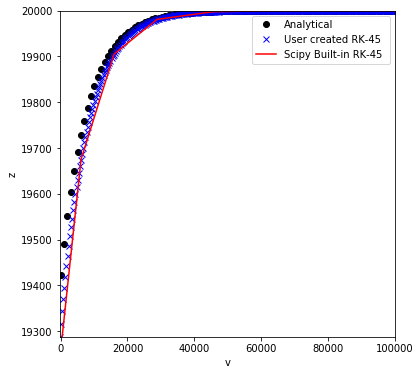

In [4]:
earth = Planet()
a = earth.compare_analytical_numerical(100, 20000, 3000, 10e5, 20)

209.94018995025579
211.5150979889464
213.09412438059894
212.51704149349777
215.1797254388359
217.85521472847174
218.35906361723121
218.86258776585902
219.3657879648316
217.68758744868177
214.93034753064924
220.87345311797606
217.01041871846104
221.87695901454975
225.68001747044488
231.73145384564802
224.48020062718973
223.88015403573092
233.2535388918853
233.76021870711904


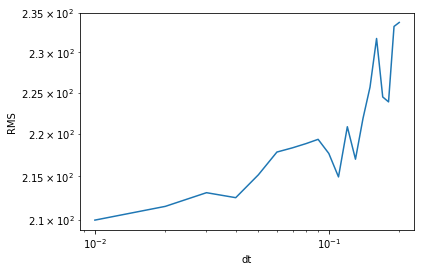

233.76021870711904

In [5]:
earth = Planet()
earth.error_analysis(10, 20000, 3000, 10e5, 20)

## Ensemble function with dask implemented for faster computation:
#### Following parameters can be choosen: Radius, Angle, Strength, Velocity, Density

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
from dask import delayed

def solve_ensemble(planet, fiducial_impact, variables, radians=False, rmin  = 8, rmax = 12):
    samples = 1000
    nval = int(11) #for bins
    Y_min, Y_max = 1e3, 10e6
    p_m, stress_p = 3000, 1000

    radius = np.full((samples,),fiducial_impact['radius'])
    angle = np.full((samples,),fiducial_impact['angle'])
    strength = np.full((samples,),fiducial_impact['strength'])
    velocity = np.full((samples,),fiducial_impact['velocity'])
    density = np.full((samples,),fiducial_impact['density'])

    columns = []

    #finding probility distribution. Using differentiation 
    for var in variables:
        if var == 'radius':
            #uniform distribution
            radius = np.random.uniform(rmin, rmax, samples)
            columns.append(radius)
        if var == 'angle':
            angles = np.linspace(0,90,nval)
            angles_dist = 2*np.sin(np.radians(angles))*np.cos(np.radians(angles))
            angles_dist = angles_dist/np.sum(angles_dist) # normalizing 
            angless = np.random.choice(angles, size=samples, p=angles_dist)
            columns.append(angless)
        if var == 'strength':
            str = np.linspace(Y_min, Y_max,nval)
            str_dist = 1/(str*4)
            str_dist = str_dist/np.sum(str_dist)
            strengths = np.random.choice(str, size=samples, p=str_dist)
            columns.append(strengths)
        if var == 'velocity':
            vlc = np.linspace(0,50000,nval) # large distance
            vlci = np.sqrt(11200**2 + vlc**2) # impact velocity
            vlc_dist = (np.sqrt(2/np.pi)*np.exp(-(vlc/1000)**2/242)*(vlc/1000)**2)/1331
            vlc_dist = vlc_dist/np.sum(vlc_dist)
            velocitys = np.random.choice(vlci, size=samples, p=vlc_dist)
            columns.append(velocitys)
        if var == 'density':
            den = np.linspace(1,7001,nval)
            den_dist = np.exp(-(den-p_m)**2/2e6)/(stress_p*np.sqrt(2*np.pi))
            den_dist = den_dist/np.sum(den_dist)
            densitys = np.random.choice(den,size=samples, p=den_dist)
            columns.append(densitys)

    # Ensemble function with Dask
    outcomes = []

    dask.config.set(scheduler = 'processes')
    for i in range(samples):
        output, outcome = delayed(planet.impact, nout=2)(radius=radius[i], angle=angle[i], strength=strength[i], velocity=velocity[i], density=density[i], init_altitude= 100000, dt = 0.05)
        outcomes.append(outcome)
    outcomes = dask.compute(*outcomes)

    # adding the varied specs and brust altitude to a dataframe
    outcomes = [t["burst_altitude"] for t in outcomes]
    columns.append(np.array(outcomes))
    columns = np.array(columns).T
    cl = columns
    final = pd.DataFrame(data = columns, columns=['Radius','Angle','Strength','Velocity','Density','Burst_Altitude'])

    return cl, final

## Simulation Running:
#### Sample size can be varied to run simulation multiple times

In [42]:
import time
earth = Planet()

fiducial_impact = {'radius': 10.0,
                   'angle': 45.0,
                   'strength': 100000.0,
                   'velocity': 21000.0,
                   'density': 3000.0}

print('Starting simulation now...')

sample_size = 2
for i in range(sample_size):
    start_time = time.time()
    ensemble = solve_ensemble(earth,fiducial_impact,
                                       variables=['angle', 'radius', 'strength', 'velocity', 'density'], radians=False,
                                       rmin=8, rmax=12)
    print(final)
    print("--- %s seconds ---" % (time.time() - start_time))

Starting simulation now...
   Radius      Angle  Strength      Velocity  Density  Burst_Altitude
0    36.0  10.324869    1000.0  15014.659503   2101.0    28403.296133
1    63.0  11.295026    1000.0  15014.659503   2101.0    27617.625696
2     9.0   8.076158    1000.0  18720.042735   1401.0    31283.126438
3    27.0  11.446729    1000.0  27394.159962   4201.0    27588.730438
4    18.0  10.424763    1000.0  27394.159962   4201.0    28380.934120
5    63.0  11.289043    1000.0  32022.492095   3501.0    27618.796334
6    54.0   9.941532    1000.0  22922.478051   3501.0    29070.765105
7    45.0   8.401924    1000.0  18720.042735   2101.0    30613.735198
8    45.0  10.551826    1000.0  18720.042735   3501.0    28353.662677
9    36.0  10.977465    1000.0  27394.159962   1401.0    27683.227872
--- 310.0216052532196 seconds ---
   Radius      Angle  Strength      Velocity  Density  Burst_Altitude
0    36.0  10.324869    1000.0  15014.659503   2101.0    28403.296133
1    63.0  11.295026    1000.

## Graphing 

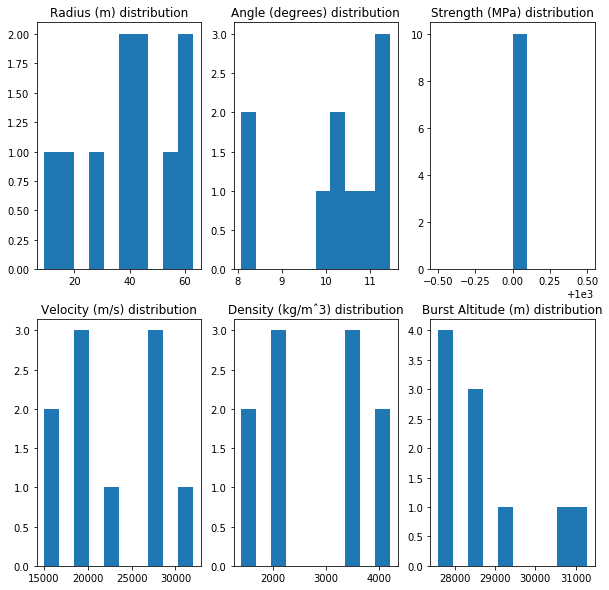

In [43]:
fig, axs = plt.subplots(2,3, figsize=(10,10))
counts, bins = np.histogram(columns[:,0])
axs[0,0].hist(bins[:-1], bins, weights=counts)
axs[0,0].set_title('Radius (m) distribution')

counts, bins = np.histogram(columns[:,1])
axs[0,1].hist(bins[:-1], bins, weights=counts)
axs[0,1].set_title('Angle (degrees) distribution')

counts, bins = np.histogram(columns[:,2])
axs[0,2].hist(bins[:-1], bins, weights=counts)
axs[0,2].set_title('Strength (MPa) distribution')

counts, bins = np.histogram(columns[:,3])
axs[1,0].hist(bins[:-1], bins, weights=counts)
axs[1,0].set_title('Velocity (m/s) distribution')   

counts, bins = np.histogram(columns[:,4])
axs[1,1].hist(bins[:-1], bins, weights=counts)
axs[1,1].set_title('Density (kg/mˆ3) distribution')

counts, bins = np.histogram(columns[:,5])
axs[1,2].hist(bins[:-1], bins, weights=counts)
axs[1,2].set_title('Burst Altitude (m) distribution')

plt.show()